In [41]:
import sys
sys.path.append('./app/')
import fileio
import preprocess
import evaluation
import pandas as pd
import numpy as np
from sklearn.linear_model import SGDClassifier
import xgboost as xgb
import matplotlib.pyplot as plt

In [39]:
def draw_para(paradict):
    df = pd.DataFrame.from_dict(paradict,orient='index')
    df.plot(figsize=(12,4))

In [4]:
dfoff ,dftest,dfon = fileio.read_all('./data/')

In [7]:
# 预处理，部分特征处理
dfoff,weekdaycols = preprocess.preprocess(dfoff)
dftest,weekdaycols = preprocess.preprocess(dftest)
# 分割测试子集和训练子集
x_train,y_train,x_test,y_test,train,valid = preprocess.split_t_v(dfoff,weekdaycols)

# 初始模型

In [92]:
model_sgd = SGDClassifier(loss='log',penalty='elasticnet',fit_intercept=True,max_iter=100,shuffle=True,
                      alpha = 0.01,l1_ratio = 0.01,n_jobs=1,class_weight=None)

model_sgd.fit(x_train, y_train)
y_pre = model_sgd.predict(x_test)
y_prob = model_sgd.predict_proba(x_test)
evaluation.get_official_auc(y_prob[:,1],y_test,valid)

D:\cx\anaconda\installthere\lib\site-packages\sklearn\metrics\_ranking.py:805: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)
D:\cx\anaconda\installthere\lib\site-packages\sklearn\metrics\_ranking.py:89: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):


0.555445399805522

In [90]:
# 3,0.81,4,== 0.5490
# 9,0.77,5 == 0.5494
model_xgb = xgb.XGBClassifier(objective='binary:logistic', n_estimators=3,subsample= 0.81, max_depth=4, n_jobs= -1)

model_xgb.fit(x_train, y_train)
y_pre = model_xgb.predict(x_test)
y_prob = model_xgb.predict_proba(x_test)
evaluation.get_official_auc(y_prob[:,1],y_test,valid)

D:\cx\anaconda\installthere\lib\site-packages\sklearn\metrics\_ranking.py:805: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)
D:\cx\anaconda\installthere\lib\site-packages\sklearn\metrics\_ranking.py:89: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):


0.5499031294776547

# 提交

In [91]:
original_feature = ['discount_rate','discount_type','discount_man', 'discount_jian','Distance', 'weekday', 'weekday_type'] + weekdaycols
final_model = model_xgb
y_test_pred = final_model.predict_proba(dftest[original_feature])
dftest1 = dftest[['User_id','Coupon_id','Date_received']].copy()
dftest1['label'] = y_test_pred[:,1]
dftest1.to_csv('submit_xgb.csv', index=False, header=False)
dftest1.head()

,User_id,Coupon_id,Date_received,label
0,4129537,9983,20160712,0.219437
1,6949378,3429,20160706,0.219437
2,2166529,6928,20160727,0.190292
3,2166529,1808,20160727,0.190292
4,6172162,6500,20160708,0.219437


# 调参

In [28]:
nestdict = {}
for nest in range(1,30,1):
    model_xgb = xgb.XGBClassifier(objective='binary:logistic', n_estimators=nest,subsample= 0.8, max_depth=13, n_jobs= -1)
    model_xgb.fit(x_train, y_train)
    y_pre = model_xgb.predict(x_test)
    y_prob = model_xgb.predict_proba(x_test)
    sco = evaluation.get_official_auc(y_prob[:,1],y_test,valid)
    nestdict[nest] = sco
    print(nest,sco)

D:\cx\anaconda\installthere\lib\site-packages\sklearn\metrics\_ranking.py:805: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)
D:\cx\anaconda\installthere\lib\site-packages\sklearn\metrics\_ranking.py:89: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):


1 0.5449104233710425
2 0.5463851982068968
3 0.5485093377424124
4 0.5465192450223564
5 0.546120095525986
6 0.5442620225980515
7 0.545416727490072
8 0.5429464656745707
9 0.5412952082200654
10 0.5418250230335778
11 0.5409171460630304
12 0.5417905998538235
13 0.5411770977424903
14 0.5403268386339439
15 0.5409658309328504
16 0.5402521943235358
17 0.5398192889218946
18 0.5395114562732428
19 0.5389820762322252
20 0.5386451495060818
21 0.5375150921692492
22 0.5388318116634017
23 0.537996177566045
24 0.5382418869606963
25 0.5371590373795783
26 0.5382717711147381
27 0.5375074254017602
28 0.5397619251089087
29 0.5397139966209193


In [49]:
subdict = {}
for sub in np.arange(0.6,1,0.01):
    model_xgb = xgb.XGBClassifier(objective='binary:logistic', n_estimators=3,subsample= sub, max_depth=13, n_jobs= -1)
    model_xgb.fit(x_train, y_train)
    y_pre = model_xgb.predict(x_test)
    y_prob = model_xgb.predict_proba(x_test)
    sco = evaluation.get_official_auc(y_prob[:,1],y_test,valid)
    subdict[sub] = sco
    print(sub,sco)

D:\cx\anaconda\installthere\lib\site-packages\sklearn\metrics\_ranking.py:805: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)
D:\cx\anaconda\installthere\lib\site-packages\sklearn\metrics\_ranking.py:89: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):


0.6 0.5479086607083647
0.61 0.5481689054967773
0.62 0.54600596086213
0.63 0.5458796349338159
0.64 0.5465253468584548
0.65 0.544186466244821
0.66 0.547257535925968
0.67 0.5469314770685137
0.68 0.5472032038694428
0.6900000000000001 0.5479418900576237
0.7000000000000001 0.5470530819148478
0.7100000000000001 0.5480220123309872
0.7200000000000001 0.5464813899585877
0.7300000000000001 0.5454581973395884
0.7400000000000001 0.5462836243322299
0.7500000000000001 0.5480310852710378
0.7600000000000001 0.5461384959910432
0.7700000000000001 0.5462019448865525
0.7800000000000001 0.5477796173278248
0.7900000000000001 0.5454734007836962
0.8000000000000002 0.5485093377424124
0.8100000000000002 0.5482432983215574
0.8200000000000002 0.5471015978919876
0.8300000000000002 0.5441082997185798
0.8400000000000002 0.5455864141445708
0.8500000000000002 0.5460918445924371
0.8600000000000002 0.5452405808715037
0.8700000000000002 0.5445383732247798
0.8800000000000002 0.5455456934722028
0.8900000000000002 0.54462262

In [57]:
mddict = {}
for sub in np.arange(1,21,1):
    model_xgb = xgb.XGBClassifier(objective='binary:logistic', n_estimators=3,subsample= 0.81, max_depth=sub, n_jobs= -1)
    model_xgb.fit(x_train, y_train)
    y_pre = model_xgb.predict(x_test)
    y_prob = model_xgb.predict_proba(x_test)
    sco = evaluation.get_official_auc(y_prob[:,1],y_test,valid)
    mddict[sub] = sco
    print(sub,sco)

D:\cx\anaconda\installthere\lib\site-packages\sklearn\metrics\_ranking.py:805: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)
D:\cx\anaconda\installthere\lib\site-packages\sklearn\metrics\_ranking.py:89: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):


1 0.5427123535151546
2 0.5456457980262582
3 0.5466838014199816
4 0.5499031294776547
5 0.5462816276684542
6 0.5470261017153805
7 0.545288866035378
8 0.54561614631004
9 0.5473338663586661
10 0.5481429903751399
11 0.5481968333273167
12 0.5481657199771336
13 0.5482432983215574
14 0.5482518501803367
15 0.5482518501803367
16 0.5482518501803367
17 0.5482518501803367
18 0.5482518501803367
19 0.5482518501803367
20 0.5482518501803367


In [63]:
n = 0
bigdict = {}
for nest in range(1,10,1):
    for sub in np.arange(0.75,0.85,0.01):
        for md in np.arange(1,10,1):
            model_xgb = xgb.XGBClassifier(objective='binary:logistic', n_estimators=nest,subsample= sub, max_depth=md, n_jobs= -1)
            model_xgb.fit(x_train, y_train)
            y_pre = model_xgb.predict(x_test)
            y_prob = model_xgb.predict_proba(x_test)
            sco = evaluation.get_official_auc(y_prob[:,1],y_test,valid)
            
            bigdict[sco] = [nest,sub,md]
            n=n+1
            print(sco,[nest,sub,md],n)

0.5427123535151546 [1, 0.75, 1] 1
0.5427123535151546 [1, 0.75, 2] 2
0.5445002667428243 [1, 0.75, 3] 3
0.548888553682501 [1, 0.75, 4] 4
0.5447150329267711 [1, 0.75, 5] 5
0.5418159600623322 [1, 0.75, 6] 6
0.5425072860658952 [1, 0.75, 7] 7
0.5432040972894788 [1, 0.75, 8] 8
0.5432357293263023 [1, 0.75, 9] 9
0.5427123535151546 [1, 0.76, 1] 10
0.5427123535151546 [1, 0.76, 2] 11
0.5445002667428243 [1, 0.76, 3] 12
0.5490999050890345 [1, 0.76, 4] 13
0.5449197428622327 [1, 0.76, 5] 14
0.5426950089544524 [1, 0.76, 6] 15
0.5429231388597765 [1, 0.76, 7] 16
0.5444147980165356 [1, 0.76, 8] 17
0.544820550049601 [1, 0.76, 9] 18
0.5427123535151546 [1, 0.77, 1] 19
0.5427123535151546 [1, 0.77, 2] 20
0.5445002667428243 [1, 0.77, 3] 21
0.5490999050890345 [1, 0.77, 4] 22
0.5449197428622327 [1, 0.77, 5] 23
0.5426945055452664 [1, 0.77, 6] 24
0.5429160652170828 [1, 0.77, 7] 25
0.5444738731030613 [1, 0.77, 8] 26
0.5415674010160155 [1, 0.77, 9] 27
0.5427123535151546 [1, 0.78, 1] 28
0.5427123535151546 [1, 0.78, 2]

0.54794039239985 [3, 0.78, 5] 212
0.548558906366237 [3, 0.78, 6] 213
0.5464315601851902 [3, 0.78, 7] 214
0.546521641420314 [3, 0.78, 8] 215
0.5459658636736708 [3, 0.78, 9] 216
0.5427123535151546 [3, 0.79, 1] 217
0.5445002667428243 [3, 0.79, 2] 218
0.5466838014199816 [3, 0.79, 3] 219
0.5499031294776547 [3, 0.79, 4] 220
0.5486275968989756 [3, 0.79, 5] 221
0.5472961446228403 [3, 0.79, 6] 222
0.5448015900579636 [3, 0.79, 7] 223
0.5466586835864735 [3, 0.79, 8] 224
0.5445220262754541 [3, 0.79, 9] 225
0.5427123535151546 [3, 0.8, 1] 226
0.5456457980262582 [3, 0.8, 2] 227
0.5466838014199816 [3, 0.8, 3] 228
0.5499031294776547 [3, 0.8, 4] 229
0.5478540051950117 [3, 0.8, 5] 230
0.5470892459742183 [3, 0.8, 6] 231
0.5456515110042821 [3, 0.8, 7] 232
0.5456948188823714 [3, 0.8, 8] 233
0.547080198417274 [3, 0.8, 9] 234
0.5427123535151546 [3, 0.81, 1] 235
0.5456457980262582 [3, 0.81, 2] 236
0.5466838014199816 [3, 0.81, 3] 237
0.5499031294776547 [3, 0.81, 4] 238
0.5462816276684542 [3, 0.81, 5] 239
0.5470

0.5473280075355611 [5, 0.81, 7] 421
0.5480998993997312 [5, 0.81, 8] 422
0.5460614976228875 [5, 0.81, 9] 423
0.5427123535151546 [5, 0.8200000000000001, 1] 424
0.5456354749128073 [5, 0.8200000000000001, 2] 425
0.5466838014199816 [5, 0.8200000000000001, 3] 426
0.54877968603086 [5, 0.8200000000000001, 4] 427
0.5498862711670736 [5, 0.8200000000000001, 5] 428
0.5457748180682872 [5, 0.8200000000000001, 6] 429
0.5476193390660395 [5, 0.8200000000000001, 7] 430
0.5454665564506898 [5, 0.8200000000000001, 8] 431
0.5458281368162256 [5, 0.8200000000000001, 9] 432
0.5427123535151546 [5, 0.8300000000000001, 1] 433
0.5456354749128073 [5, 0.8300000000000001, 2] 434
0.5466838014199816 [5, 0.8300000000000001, 3] 435
0.549616275808909 [5, 0.8300000000000001, 4] 436
0.5485569792046556 [5, 0.8300000000000001, 5] 437
0.5483962951228057 [5, 0.8300000000000001, 6] 438
0.5464732322466643 [5, 0.8300000000000001, 7] 439
0.5459246913266852 [5, 0.8300000000000001, 8] 440
0.5475315476506121 [5, 0.8300000000000001, 9]

0.5427123535151546 [7, 0.8400000000000001, 1] 622
0.5483135212126616 [7, 0.8400000000000001, 2] 623
0.5465315971702355 [7, 0.8400000000000001, 3] 624
0.5500970314827199 [7, 0.8400000000000001, 4] 625
0.5513055135208718 [7, 0.8400000000000001, 5] 626
0.5473209102234528 [7, 0.8400000000000001, 6] 627
0.5473143886546793 [7, 0.8400000000000001, 7] 628
0.5446609806514056 [7, 0.8400000000000001, 8] 629
0.5447351024581341 [7, 0.8400000000000001, 9] 630
0.5466838014199816 [8, 0.75, 1] 631
0.5483135212126616 [8, 0.75, 2] 632
0.5477838203569941 [8, 0.75, 3] 633
0.5516112191610835 [8, 0.75, 4] 634
0.5522303835060595 [8, 0.75, 5] 635
0.5509826837620773 [8, 0.75, 6] 636
0.548339687464954 [8, 0.75, 7] 637
0.5467237593816134 [8, 0.75, 8] 638
0.5451492707337302 [8, 0.75, 9] 639
0.5466838014199816 [8, 0.76, 1] 640
0.5483740555468609 [8, 0.76, 2] 641
0.546813303225777 [8, 0.76, 3] 642
0.5517843344326558 [8, 0.76, 4] 643
0.5513751197978016 [8, 0.76, 5] 644
0.5510074376710622 [8, 0.76, 6] 645
0.5489599726

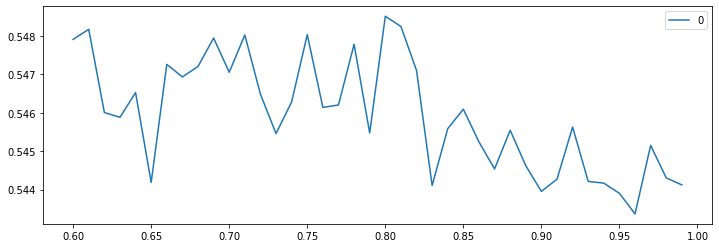

In [50]:
draw_para(subdict)

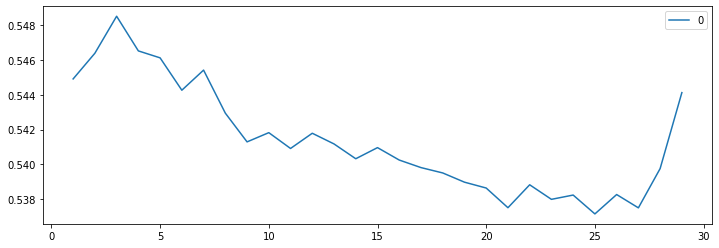

In [48]:
#nestdict = pa
draw_para(nestdict)

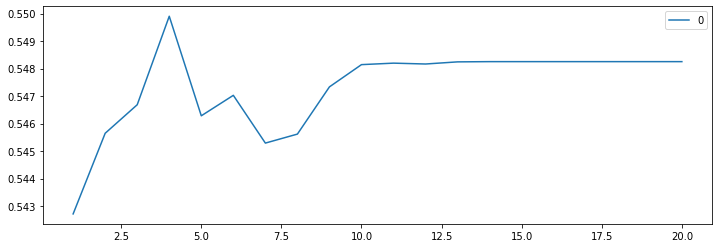

In [58]:
draw_para(mddict)

0.544567    1
0.546264    1
0.547888    1
0.546442    1
0.547093    1
           ..
0.549546    1
0.544686    1
0.548953    1
0.545386    1
0.546202    1
Length: 530, dtype: int64

In [60]:
allpara = {}
allpara['nest'] = nestdict
allpara['sub'] = subdict
allpara['md'] = mddict

In [74]:
dfbig = pd.DataFrame.from_dict(bigdict,orient='index')

In [85]:
dfbig.sort_index()

,0,1,2
0.540704,2,0.77,9
0.541567,1,0.77,9
0.541622,1,0.82,6
0.541623,1,0.83,6
0.541816,1,0.75,6
...,...,...,...
0.552969,8,0.78,6
0.553049,9,0.81,4
0.553135,7,0.78,6
0.553901,9,0.79,5


(array([  5.,  18.,  41.,  97., 102., 114.,  61.,  45.,  35.,  12.]),
 array([0.54070435, 0.54202624, 0.54334812, 0.54467   , 0.54599189,
        0.54731377, 0.54863565, 0.54995753, 0.55127942, 0.5526013 ,
        0.55392318]),
 <a list of 10 Patch objects>)

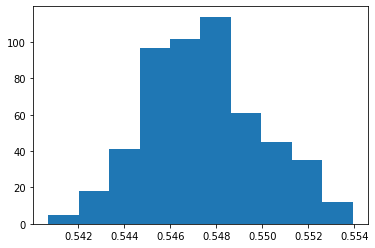

In [81]:
plt.hist(dfbig.index)